##  rna_S1_preprocessing 
Starsolo alignment Hrv107+Hrv124 single cell
Reference HUMAN + PARASITES COMBINED

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
%matplotlib inline

import seaborn as sns
import seaborn as sb
import anndata
import matplotlib as mpl
import pickle 
import scrublet as scr

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

def Barplot(which_var, adata, var='leiden', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', dpi=100, orientation='landscape', format= 'pdf')
    
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/preprocessing/'

sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1


'/opt/conda/bin/python'

## Import meta data

In [2]:
data_dir ='/nfs/team292/rh26/16_explant_sc_2D9_stars_combine/'

In [3]:
meta = pd.read_csv(data_dir+'metadata/meta_exp_infection_2d9_scell.csv',index_col=0)
meta['stage'] = meta['stage'].astype('str')
plotmeta = list(meta.columns)
plotmeta.append('sample')
print('Number of samples: ', meta.index.size)

Number of samples:  4


In [4]:
meta

stage donor_id
sample                             
Pla_HDBR11345029   day2_UI   Hrv107
Pla_HDBR11345030  day2_INF   Hrv107
Pla_HDBR11345033   day2_UI   Hrv124
Pla_HDBR11345034  day2_INF   Hrv124

## Load GeneFull/filtered STARsolo outputs
### Preprocessing and merge matrix

In [5]:
data_dir2='/warehouse/cellgeni/tic-1471/'

Note: for parasites, skip basic filtering. Do filetering at later step.

In [6]:
holder = []
for sample in meta.index:
    print(sample)
    holder.append(sc.read_10x_mtx(data_dir2+sample+'/output/GeneFull/filtered/',var_names='gene_symbols',cache=True)) 
    # Set names of observation as sample + _ + barcode/probe
    holder[-1].var_names_make_unique()
    holder[-1].obs_names = [sample+'_'+i.split('-')[0] for i in holder[-1].obs_names]
    #Filer cells with less than 100 genes expressed
    #sc.pp.filter_cells(holder[-1], min_genes=100)
    #Filer genes expressed in less than 3 cells
    #sc.pp.filter_genes(holder[-1], min_cells=3)
    # add in metadata
    holder[-1].obs['sample'] = sample 
    for val in meta.columns:
        holder[-1].obs[val] = meta[val][sample]
    # Extract mitochondial genes
    mito_genes = [name for name in holder[-1].var_names if name.startswith('MT')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    holder[-1].obs['percent_mito'] = np.sum(
        holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1
    #add the total counts per cell as observations-annotation to adata
    holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1
    holder[-1].obs['n_genes'] = holder[-1].X.sum(axis=1).A1
    print('Total number of cells: {:d}'.format(holder[-1].n_obs))
    print('Total number of genes: {:d}'.format(holder[-1].n_vars))

Pla_HDBR11345029
Total number of cells: 19111
Total number of genes: 42294
Pla_HDBR11345030
Total number of cells: 24603
Total number of genes: 42294
Pla_HDBR11345033
Total number of cells: 13495
Total number of genes: 42294
Pla_HDBR11345034
Total number of cells: 17648
Total number of genes: 42294


In [7]:
# confirm N samples
print(len(holder))
# merge datasets by taking the intersection of cells found between nucleis and cells 
adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)#batch_key='sample')
# copy of this matrix in Compressed Sparse Row format
adata.X = adata.X.tocsr()
adata

4


AnnData object with n_obs × n_vars = 74857 × 42294
    obs: 'sample', 'stage', 'donor_id', 'percent_mito', 'n_counts', 'n_genes', 'batch'
    var: 'gene_ids', 'feature_types'

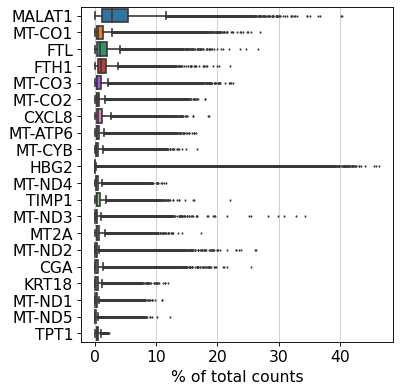

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [9]:
adata.obs.head()

sample    stage donor_id  \
Pla_HDBR11345029_AAACCCAAGACATCAA  Pla_HDBR11345029  day2_UI   Hrv107   
Pla_HDBR11345029_AAACCCAAGCTTAAGA  Pla_HDBR11345029  day2_UI   Hrv107   
Pla_HDBR11345029_AAACCCAAGGTTATAG  Pla_HDBR11345029  day2_UI   Hrv107   
Pla_HDBR11345029_AAACCCACAAATCCCA  Pla_HDBR11345029  day2_UI   Hrv107   
Pla_HDBR11345029_AAACCCACAAGGTCAG  Pla_HDBR11345029  day2_UI   Hrv107   

                                   percent_mito  n_counts  n_genes batch  
Pla_HDBR11345029_AAACCCAAGACATCAA      0.053661    6802.0   6802.0     0  
Pla_HDBR11345029_AAACCCAAGCTTAAGA      0.017683    4920.0   4920.0     0  
Pla_HDBR11345029_AAACCCAAGGTTATAG      0.038199   14346.0  14346.0     0  
Pla_HDBR11345029_AAACCCACAAATCCCA      0.002563    4292.0   4292.0     0  
Pla_HDBR11345029_AAACCCACAAGGTCAG      0.023510    1191.0   1191.0     0

In [10]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True, save='.pdf', show=False)
sc.pl.scatter(adata, x='n_counts', y='percent_mito', save='_numi_vs_mito.pdf', show=False)
sc.pl.scatter(adata, x='n_counts', y='n_genes', save='_numi_vs_ngenes.pdf', show=False)

... storing 'sample' as categorical
... storing 'stage' as categorical
... storing 'donor_id' as categorical
... storing 'feature_types' as categorical


## QC plots

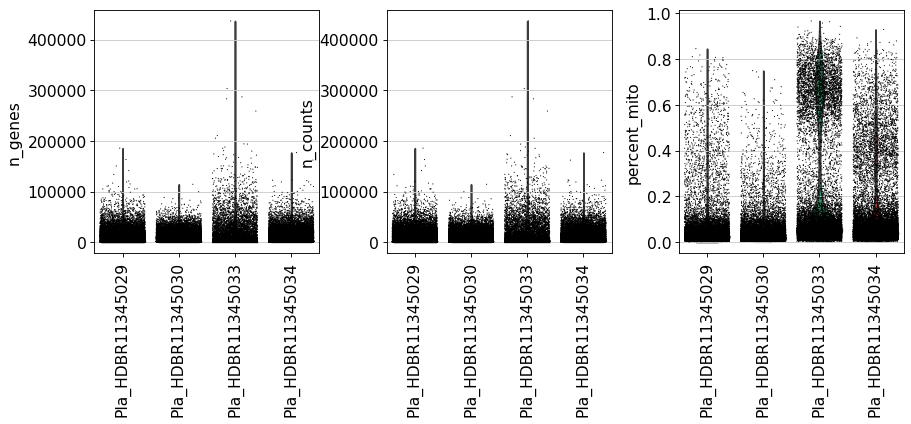

In [11]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], groupby='sample', rotation = 90, jitter=0.4, save='_persample.pdf', show=True)

In [12]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
pd.DataFrame(adata.obs).to_csv(str(sc.settings.figdir)+'/metadata_prefilters.csv')

Total number of cells: 74857
Total number of genes: 42294


## Check if you are able to detect parasite transcripts

In [13]:
adata.var

gene_ids    feature_types
MIR1302-2HG    ENSG00000243485  Gene Expression
FAM138A        ENSG00000237613  Gene Expression
OR4F5          ENSG00000186092  Gene Expression
AL627309.1     ENSG00000238009  Gene Expression
AL627309.3     ENSG00000239945  Gene Expression
...                        ...              ...
RIF-180          PF3D7_0115300  Gene Expression
PF3D7_0115400    PF3D7_0115400  Gene Expression
PF3D7_0115500    PF3D7_0115500  Gene Expression
RIF-181          PF3D7_0115600  Gene Expression
VAR-79           PF3D7_0115700  Gene Expression

[42294 rows x 2 columns]

In [14]:
pf= adata.var.gene_ids.str.startswith('PF3D7')
print(sum(pf))

5690


## Filter cells with few genes
Check number of genes per cell distribution and filter cells accordingly

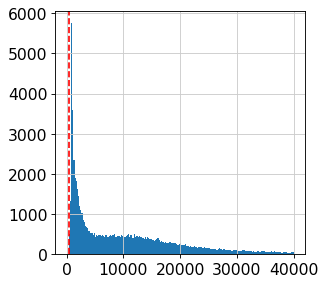

In [15]:
plt.hist(adata.obs['n_genes'], bins = 200, range=(0, 40000))
plt.axvline(500, linestyle = '--', color = 'red')

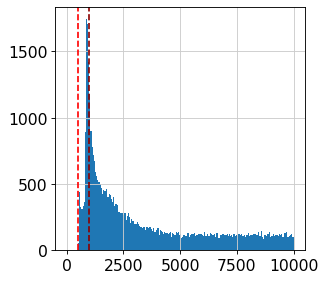

In [16]:
plt.hist(adata.obs['n_counts'], bins = 200, range=(0, 10000))
plt.axvline(500, linestyle = '--', color = 'red')
plt.axvline(1000, linestyle = '--', color = 'darkred')

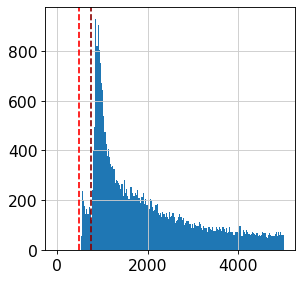

In [17]:
plt.hist(adata.obs['n_genes'], bins = 200, range=(0, 5000))
plt.axvline(500, linestyle = '--', color = 'red')
plt.axvline(750, linestyle = '--', color = 'darkred')

In [18]:
sc.pp.filter_cells(adata, min_genes=750)
adata.X.shape

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(57692, 42294)

In [19]:
adata.var

gene_ids    feature_types
MIR1302-2HG    ENSG00000243485  Gene Expression
FAM138A        ENSG00000237613  Gene Expression
OR4F5          ENSG00000186092  Gene Expression
AL627309.1     ENSG00000238009  Gene Expression
AL627309.3     ENSG00000239945  Gene Expression
...                        ...              ...
RIF-180          PF3D7_0115300  Gene Expression
PF3D7_0115400    PF3D7_0115400  Gene Expression
PF3D7_0115500    PF3D7_0115500  Gene Expression
RIF-181          PF3D7_0115600  Gene Expression
VAR-79           PF3D7_0115700  Gene Expression

[42294 rows x 2 columns]

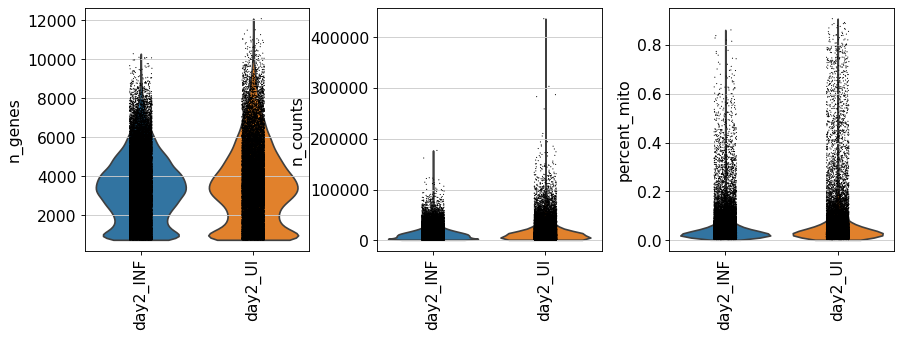

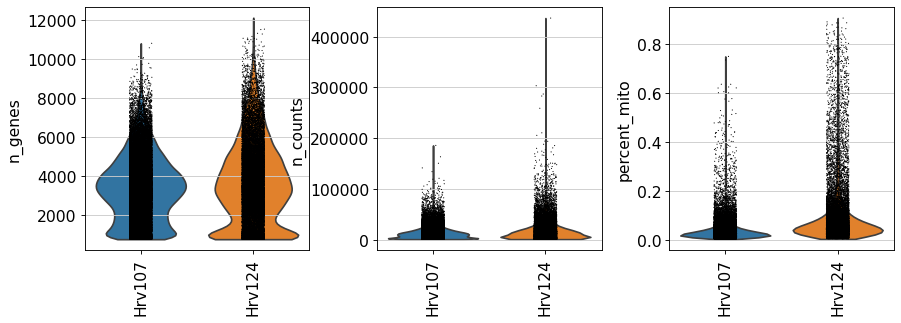

In [20]:
sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'], rotation=90, groupby='stage') 
sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'], rotation=90, groupby='donor_id') 

## Filter cells with large % mitochondrial genes

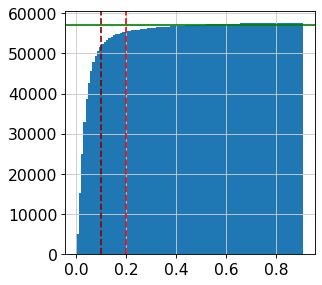

In [21]:
plt.hist(adata.obs['percent_mito'], bins = 100, cumulative=True)
plt.axvline(0.2, linestyle = '--', color = 'red')
plt.axvline(0.1, linestyle = '--', color = 'darkred')
plt.axhline(adata.n_obs*0.99, linestyle = '-', color = 'green')

In [22]:
adata = adata[adata.obs['percent_mito'] < 0.2, :]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [23]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['sample'].values.describe()

Total number of cells: 55409
Total number of genes: 42294


counts     freqs
categories                        
Pla_HDBR11345029   15184  0.274035
Pla_HDBR11345030   21022  0.379397
Pla_HDBR11345033    5853  0.105633
Pla_HDBR11345034   13350  0.240936

In [24]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['stage'].values.describe()

Total number of cells: 55409
Total number of genes: 42294


counts     freqs
categories                  
day2_INF     34372  0.620332
day2_UI      21037  0.379668

### Remove cells with low counts high mito combo

In [25]:
x = [ int(i) < 2000 for i in adata.obs['n_counts']]
adata.obs['low_ncounts'] = [ str(i) for i in x ]

y = [ i > 0.1 for i in adata.obs['percent_mito']]
adata.obs['high_mito'] = [ str(i) for i in y ]

mask = [all(tup) for tup in zip(x,y)]
adata.obs['low_ncounts_high_mito'] = [ str(i) for i in mask ]
# there is a bug so I have to iterate ... sorry 

Trying to set attribute `.obs` of view, copying.


In [26]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor_id'].values.describe()
pd.DataFrame(adata.obs).to_csv(str(sc.settings.figdir)+'/metadata_filtered.csv')

Total number of cells: 55409
Total number of genes: 42294


### Filter genes expressed in less than 3 cells

In [27]:
sc.pp.filter_genes(adata, min_cells=3)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [28]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

Total number of cells: 55409
Total number of genes: 35220


In [29]:
adata.obs['sample'].values.describe()

counts     freqs
categories                        
Pla_HDBR11345029   15184  0.274035
Pla_HDBR11345030   21022  0.379397
Pla_HDBR11345033    5853  0.105633
Pla_HDBR11345034   13350  0.240936

In [29]:
adata.var

gene_ids    feature_types  n_cells
MIR1302-2HG    ENSG00000243485  Gene Expression       24
AL627309.1     ENSG00000238009  Gene Expression      869
AL627309.2     ENSG00000239906  Gene Expression       11
AL627309.5     ENSG00000241860  Gene Expression     1313
AL627309.4     ENSG00000241599  Gene Expression        4
...                        ...              ...      ...
PF3D7_0113200    PF3D7_0113200  Gene Expression       19
PF3D7_0113300    PF3D7_0113300  Gene Expression        3
SURF1.2          PF3D7_0113600  Gene Expression        5
HSP40            PF3D7_0113700  Gene Expression        4
VAR-79           PF3D7_0115700  Gene Expression      104

[35220 rows x 3 columns]

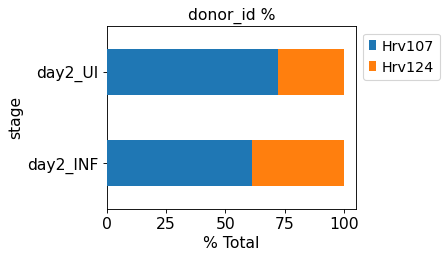

In [30]:
def Barplot(which_var, adata, var='stage', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (4,height), fontsize = 14, grid = False,)
    else: 
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (4,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_xlabel('% Total')
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', dpi=300, orientation='landscape', format= 'pdf',  bbox_inches='tight')
Barplot('donor_id', adata)

In [31]:
adata.var['hum'] = adata.var.gene_ids.str.startswith('ENSG') ## all human genes
adata.var['pf'] = adata.var.gene_ids.str.startswith('PF3D7') ## all malaria genes

sc.pp.calculate_qc_metrics(adata, qc_vars=['hum'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['pf'], percent_top=None, log1p=False, inplace=True)

In [32]:
adata.obs.tail()

sample     stage donor_id  \
Pla_HDBR11345034_TTTGTTGGTGGAGAAA  Pla_HDBR11345034  day2_INF   Hrv124   
Pla_HDBR11345034_TTTGTTGGTGTTTGCA  Pla_HDBR11345034  day2_INF   Hrv124   
Pla_HDBR11345034_TTTGTTGGTTATGTGC  Pla_HDBR11345034  day2_INF   Hrv124   
Pla_HDBR11345034_TTTGTTGTCCTGGGAC  Pla_HDBR11345034  day2_INF   Hrv124   
Pla_HDBR11345034_TTTGTTGTCGTAGAGG  Pla_HDBR11345034  day2_INF   Hrv124   

                                   percent_mito  n_counts  n_genes batch  \
Pla_HDBR11345034_TTTGTTGGTGGAGAAA      0.069981   19934.0     4962     3   
Pla_HDBR11345034_TTTGTTGGTGTTTGCA      0.048871   18907.0     4645     3   
Pla_HDBR11345034_TTTGTTGGTTATGTGC      0.013085    6343.0     2767     3   
Pla_HDBR11345034_TTTGTTGTCCTGGGAC      0.025543   15151.0     3834     3   
Pla_HDBR11345034_TTTGTTGTCGTAGAGG      0.021450   21259.0     4289     3   

                                  low_ncounts high_mito low_ncounts_high_mito  \
Pla_HDBR11345034_TTTGTTGGTGGAGAAA       False     False                 False   
Pla_HDBR11345034_TTTGTTGGTGTTTGCA       False     False                 False   
Pla_HDBR11345034_TTTGTTGGTTATGTGC       False     False                 False   
Pla_HDBR11345034_TTTGTTGTCCTGGGAC       False     False                 False   
Pla_HDBR11345034_TTTGTTGTCGTAGAGG       False     False                 False   

                                   n_genes_by_counts  total_counts  \
Pla_HDBR11345034_TTTGTTGGTGGAGAAA               4962       19934.0   
Pla_HDBR11345034_TTTGTTGGTGTTTGCA               4645       18907.0   
Pla_HDBR11345034_TTTGTTGGTTATGTGC               2767        6343.0   
Pla_HDBR11345034_TTTGTTGTCCTGGGAC               3834       15151.0   
Pla_HDBR11345034_TTTGTTGTCGTAGAGG               4289       21259.0   

                                   total_counts_hum  pct_counts_hum  \
Pla_HDBR11345034_TTTGTTGGTGGAGAAA           19934.0      100.000000   
Pla_HDBR11345034_TTTGTTGGTGTTTGCA           18905.0       99.989418   
Pla_HDBR11345034_TTTGTTGGTTATGTGC            6343.0      100.000000   
Pla_HDBR11345034_TTTGTTGTCCTGGGAC           15151.0      100.000000   
Pla_HDBR11345034_TTTGTTGTCGTAGAGG           21258.0       99.995300   

                                   total_counts_pf  pct_counts_pf  
Pla_HDBR11345034_TTTGTTGGTGGAGAAA              0.0       0.000000  
Pla_HDBR11345034_TTTGTTGGTGTTTGCA              2.0       0.010578  
Pla_HDBR11345034_TTTGTTGGTTATGTGC              0.0       0.000000  
Pla_HDBR11345034_TTTGTTGTCCTGGGAC              0.0       0.000000  
Pla_HDBR11345034_TTTGTTGTCGTAGAGG              1.0       0.004704

... storing 'low_ncounts' as categorical
... storing 'high_mito' as categorical
... storing 'low_ncounts_high_mito' as categorical


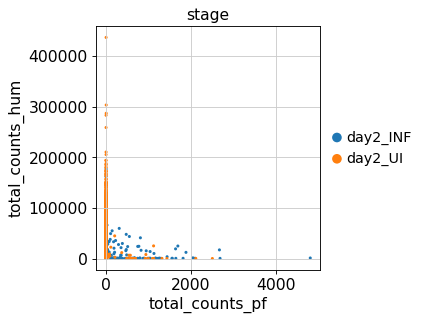

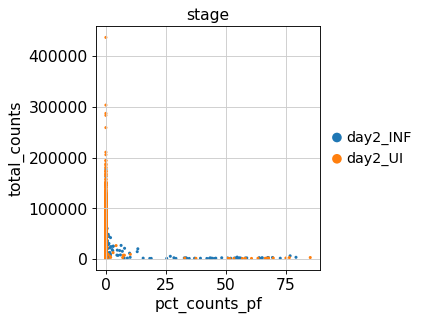

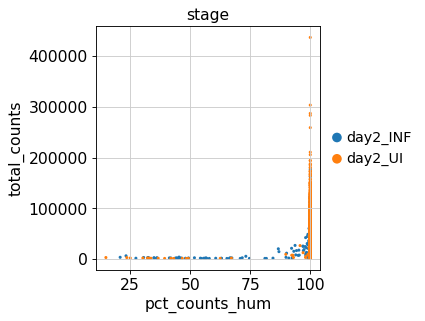

In [33]:
sc.pl.scatter(adata, x='total_counts_pf', y='total_counts_hum', color="stage", size=30)
sc.pl.scatter(adata, x='pct_counts_pf', y='total_counts', color="stage", size=30)
sc.pl.scatter(adata, x='pct_counts_hum', y='total_counts', color="stage", size=30)

In [34]:
# percentage in a droplet has mostly human genes
#sum(adata.obs.pct_counts_hum > 95)
sum(adata.obs.pct_counts_hum > 90)
#sum(adata.obs.pct_counts_hum > 80)

55342

In [35]:
sum(adata.obs.total_counts_pf > 200)

97

In [36]:
#Create a new metainfo for obs based on pct_counts mapping to hum or parasites; > 100 umi counts 
adata.obs['stage_0'] = 'hum'
pf= adata.obs.total_counts_pf > 100
adata.obs.loc[pf, 'stage_0'] = 'pf_0'

In [37]:
adata.obs.tail()

sample     stage donor_id  \
Pla_HDBR11345034_TTTGTTGGTGGAGAAA  Pla_HDBR11345034  day2_INF   Hrv124   
Pla_HDBR11345034_TTTGTTGGTGTTTGCA  Pla_HDBR11345034  day2_INF   Hrv124   
Pla_HDBR11345034_TTTGTTGGTTATGTGC  Pla_HDBR11345034  day2_INF   Hrv124   
Pla_HDBR11345034_TTTGTTGTCCTGGGAC  Pla_HDBR11345034  day2_INF   Hrv124   
Pla_HDBR11345034_TTTGTTGTCGTAGAGG  Pla_HDBR11345034  day2_INF   Hrv124   

                                   percent_mito  n_counts  n_genes batch  \
Pla_HDBR11345034_TTTGTTGGTGGAGAAA      0.069981   19934.0     4962     3   
Pla_HDBR11345034_TTTGTTGGTGTTTGCA      0.048871   18907.0     4645     3   
Pla_HDBR11345034_TTTGTTGGTTATGTGC      0.013085    6343.0     2767     3   
Pla_HDBR11345034_TTTGTTGTCCTGGGAC      0.025543   15151.0     3834     3   
Pla_HDBR11345034_TTTGTTGTCGTAGAGG      0.021450   21259.0     4289     3   

                                  low_ncounts high_mito low_ncounts_high_mito  \
Pla_HDBR11345034_TTTGTTGGTGGAGAAA       False     False                 False   
Pla_HDBR11345034_TTTGTTGGTGTTTGCA       False     False                 False   
Pla_HDBR11345034_TTTGTTGGTTATGTGC       False     False                 False   
Pla_HDBR11345034_TTTGTTGTCCTGGGAC       False     False                 False   
Pla_HDBR11345034_TTTGTTGTCGTAGAGG       False     False                 False   

                                   n_genes_by_counts  total_counts  \
Pla_HDBR11345034_TTTGTTGGTGGAGAAA               4962       19934.0   
Pla_HDBR11345034_TTTGTTGGTGTTTGCA               4645       18907.0   
Pla_HDBR11345034_TTTGTTGGTTATGTGC               2767        6343.0   
Pla_HDBR11345034_TTTGTTGTCCTGGGAC               3834       15151.0   
Pla_HDBR11345034_TTTGTTGTCGTAGAGG               4289       21259.0   

                                   total_counts_hum  pct_counts_hum  \
Pla_HDBR11345034_TTTGTTGGTGGAGAAA           19934.0      100.000000   
Pla_HDBR11345034_TTTGTTGGTGTTTGCA           18905.0       99.989418   
Pla_HDBR11345034_TTTGTTGGTTATGTGC            6343.0      100.000000   
Pla_HDBR11345034_TTTGTTGTCCTGGGAC           15151.0      100.000000   
Pla_HDBR11345034_TTTGTTGTCGTAGAGG           21258.0       99.995300   

                                   total_counts_pf  pct_counts_pf stage_0  
Pla_HDBR11345034_TTTGTTGGTGGAGAAA              0.0       0.000000     hum  
Pla_HDBR11345034_TTTGTTGGTGTTTGCA              2.0       0.010578     hum  
Pla_HDBR11345034_TTTGTTGGTTATGTGC              0.0       0.000000     hum  
Pla_HDBR11345034_TTTGTTGTCCTGGGAC              0.0       0.000000     hum  
Pla_HDBR11345034_TTTGTTGTCGTAGAGG              1.0       0.004704     hum

In [38]:
adata.obs['stage_0'].value_counts()

hum     55301
pf_0      108
Name: stage_0, dtype: int64

In [39]:
adata

AnnData object with n_obs × n_vars = 55409 × 35220
    obs: 'sample', 'stage', 'donor_id', 'percent_mito', 'n_counts', 'n_genes', 'batch', 'low_ncounts', 'high_mito', 'low_ncounts_high_mito', 'n_genes_by_counts', 'total_counts', 'total_counts_hum', 'pct_counts_hum', 'total_counts_pf', 'pct_counts_pf', 'stage_0'
    var: 'gene_ids', 'feature_types', 'n_cells', 'hum', 'pf', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors', 'stage_colors', 'donor_id_colors'

In [40]:
adata_pf_b =adata[[i in ['pf_0'] for i in adata.obs['stage_0']]]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [41]:
adata_pf_b.obs['stage'].value_counts()

day2_INF    82
day2_UI     26
Name: stage, dtype: int64

## Calculate cell-cycle scores AND (optional)regress out cell cycle genes

We here perform cell cycle scoring. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.

First read the file with cell cycle genes, from Regev lab and split into S and G2M phase genes. Cell cycle genes were retrieved from the scanpy_usage github site via web browser at RegevLab Github repo.

In [42]:
# Regress out cell cycle genes
data_dir='/nfs/team292/rh26/10_explant_nuclei_2D9parasite_stars/'
cell_cycle_genes = [x.strip() for x in open(data_dir+'regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
# sc.pp.regress_out(adata, ['S_score', 'G2M_score']

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [43]:
adata

AnnData object with n_obs × n_vars = 55409 × 35220
    obs: 'sample', 'stage', 'donor_id', 'percent_mito', 'n_counts', 'n_genes', 'batch', 'low_ncounts', 'high_mito', 'low_ncounts_high_mito', 'n_genes_by_counts', 'total_counts', 'total_counts_hum', 'pct_counts_hum', 'total_counts_pf', 'pct_counts_pf', 'stage_0', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'n_cells', 'hum', 'pf', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors', 'stage_colors', 'donor_id_colors'

## Load scrublet

In [44]:
scorenames = ['scrublet_score','scrublet_cluster_score','zscore','bh_pval','bonf_pval']

scrdf = []
for sample in meta.index:
    scrdf.append(pd.read_csv('star-scrublet-scores/'+sample+'.csv', header=0, index_col=0))
scrdf = pd.concat(scrdf)
scrdf.index = [i.replace('-1', '') for i in scrdf.index]
for score in scorenames:
    adata.obs[score] = scrdf[score]
adata.obs['is_doublet'] = adata.obs['bonf_pval'] < 0.01
adata.obs['is_doublet_0.05'] = adata.obs['bonf_pval'] < 0.05

### Save raw counts

In [45]:
adata.raw = adata.copy()
adata.write('S1_rna_counts_adata.h5ad')

... storing 'stage_0' as categorical
... storing 'phase' as categorical


## Normalize per cell, log transform and DIM reduction
After removing unwanted cells and genes from the dataset, the next step is to normalize the data. By default, we employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result.

In [46]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


### PCA
**1. Filter HVGs in bdata and do PCA with them**

In [47]:
# Filter HVGs
bdata = adata.copy()
sc.pp.highly_variable_genes(bdata, min_mean=0.0125, max_mean=3, min_disp=0.5)
for col in ['highly_variable','means', 'dispersions', 'dispersions_norm']:
    adata.var[col] = bdata.var[col]
bdata = bdata[:, bdata.var['highly_variable']]
print('Total number of cells: {:d}'.format(bdata.n_obs))
print('Total number of genes: {:d}'.format(bdata.n_vars))

sc.pp.scale(bdata, max_value=10)
sc.tl.pca(bdata, svd_solver='arpack', n_comps=50)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Total number of cells: 55409
Total number of genes: 2601


/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


**2. Transfer PCA to the main adata**

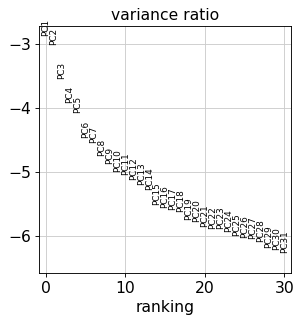

In [48]:
#fill NaNs with False so that subsetting to HVGs is possible
adata.var['highly_variable'].fillna(value=False, inplace=True)
adata.obsm['X_pca'] = bdata.obsm['X_pca'].copy()
adata.uns['pca'] = bdata.uns['pca'].copy()
adata.varm['PCs'] = np.zeros(shape=(adata.n_vars, 50))
adata.varm['PCs'][adata.var['highly_variable']] = bdata.varm['PCs']
sc.pl.pca_variance_ratio(adata, log=True, save='.pdf')

## UMAP

In [49]:
n_pcs = 30 
sc.pp.neighbors(adata, n_pcs = n_pcs)
sc.tl.umap(adata)

In [50]:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib.colors import LinearSegmentedColormap

import matplotlib

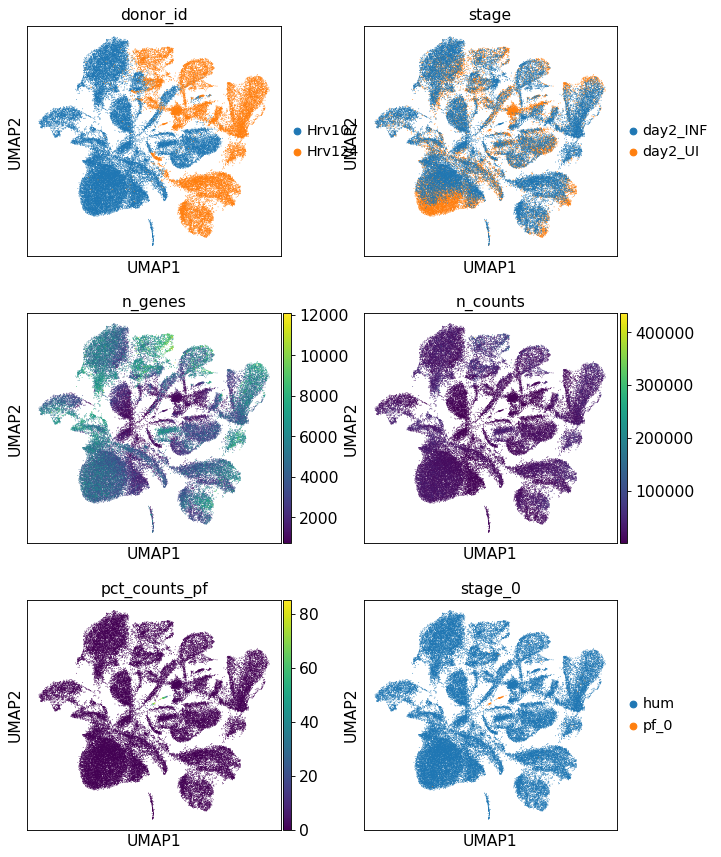

In [51]:
sc.pl.umap(adata, color=['donor_id','stage', 'n_genes', 'n_counts','pct_counts_pf', 'stage_0' ], ncols = 2, 
           save='_preprocessing.pdf')

In [52]:
adata.obs['is_doublet'].value_counts()

False    52765
True      2644
Name: is_doublet, dtype: int64

In [53]:
adata.obs['is_doublet_0.05'].value_counts()

False    52717
True      2692
Name: is_doublet_0.05, dtype: int64

In [54]:
adata

AnnData object with n_obs × n_vars = 55409 × 35220
    obs: 'sample', 'stage', 'donor_id', 'percent_mito', 'n_counts', 'n_genes', 'batch', 'low_ncounts', 'high_mito', 'low_ncounts_high_mito', 'n_genes_by_counts', 'total_counts', 'total_counts_hum', 'pct_counts_hum', 'total_counts_pf', 'pct_counts_pf', 'stage_0', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'is_doublet_0.05'
    var: 'gene_ids', 'feature_types', 'n_cells', 'hum', 'pf', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'sample_colors', 'stage_colors', 'donor_id_colors', 'log1p', 'pca', 'neighbors', 'umap', 'stage_0_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

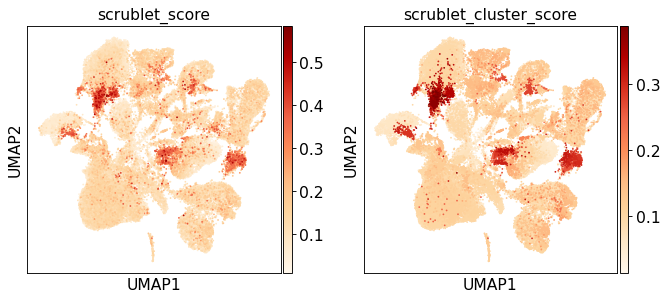

In [55]:
sc.pl.umap(adata, color=['scrublet_score', 'scrublet_cluster_score'],size=10, color_map='OrRd', 
           save='_scrublet.pdf')

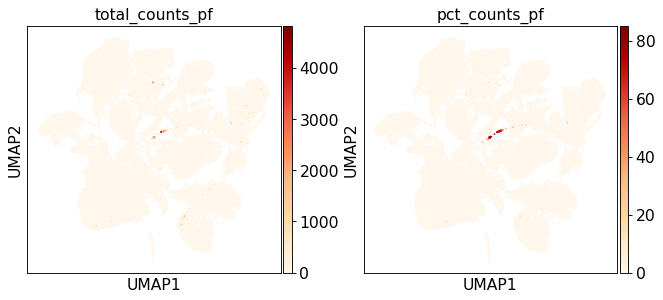

In [56]:
sc.pl.umap(adata, color=['total_counts_pf', 'pct_counts_pf'],size=10, color_map='OrRd')

## Visualize some general markers

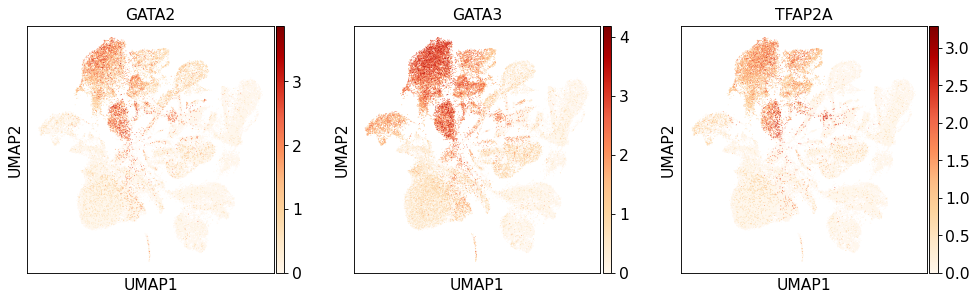

In [57]:
sc.pl.umap(adata, color=[ 'GATA2', 'GATA3', 'TFAP2A'],color_map='OrRd', use_raw=False)

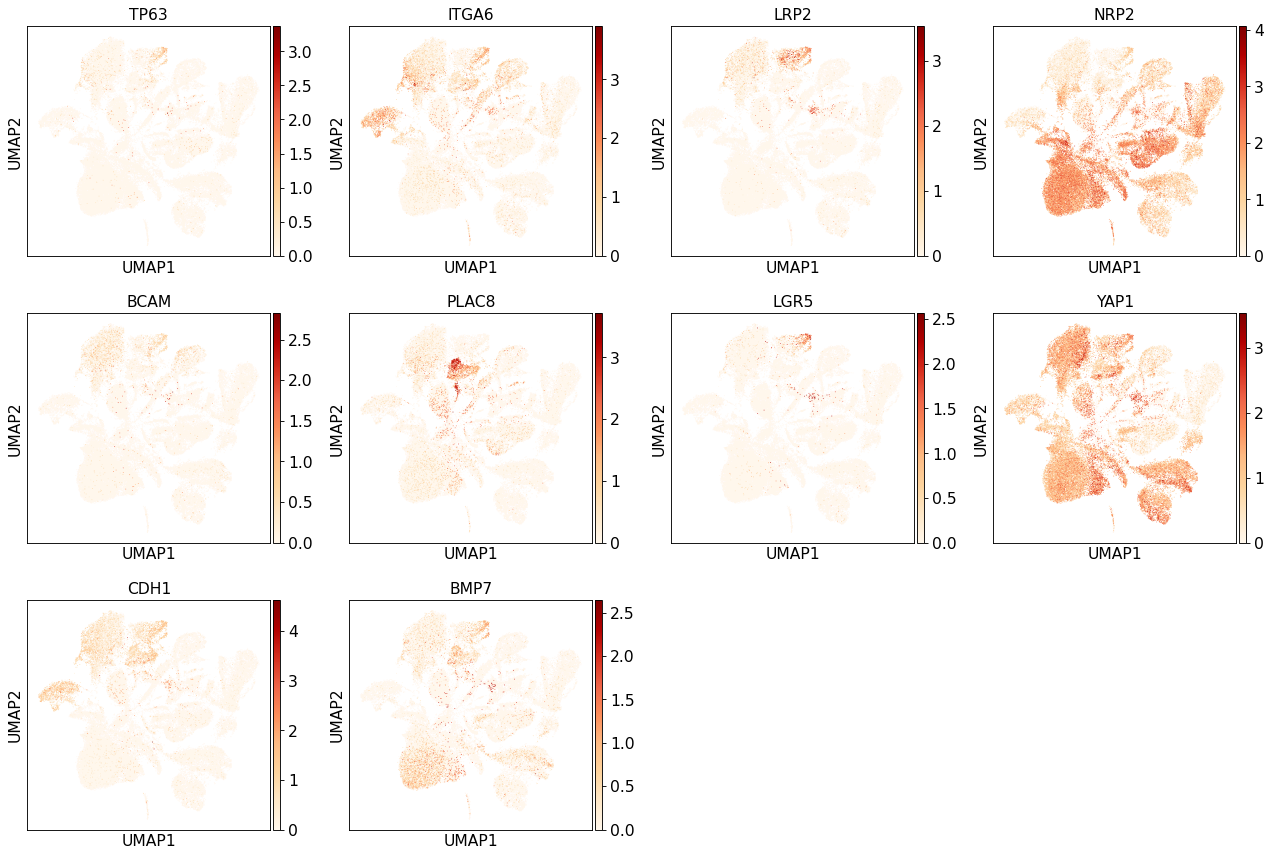

In [58]:
sc.pl.umap(adata, color=[ 'TP63','ITGA6', 'LRP2', 'NRP2', 'BCAM', 'PLAC8', 'LGR5', 'YAP1', 'CDH1', 'BMP7'],color_map='OrRd', use_raw=False)

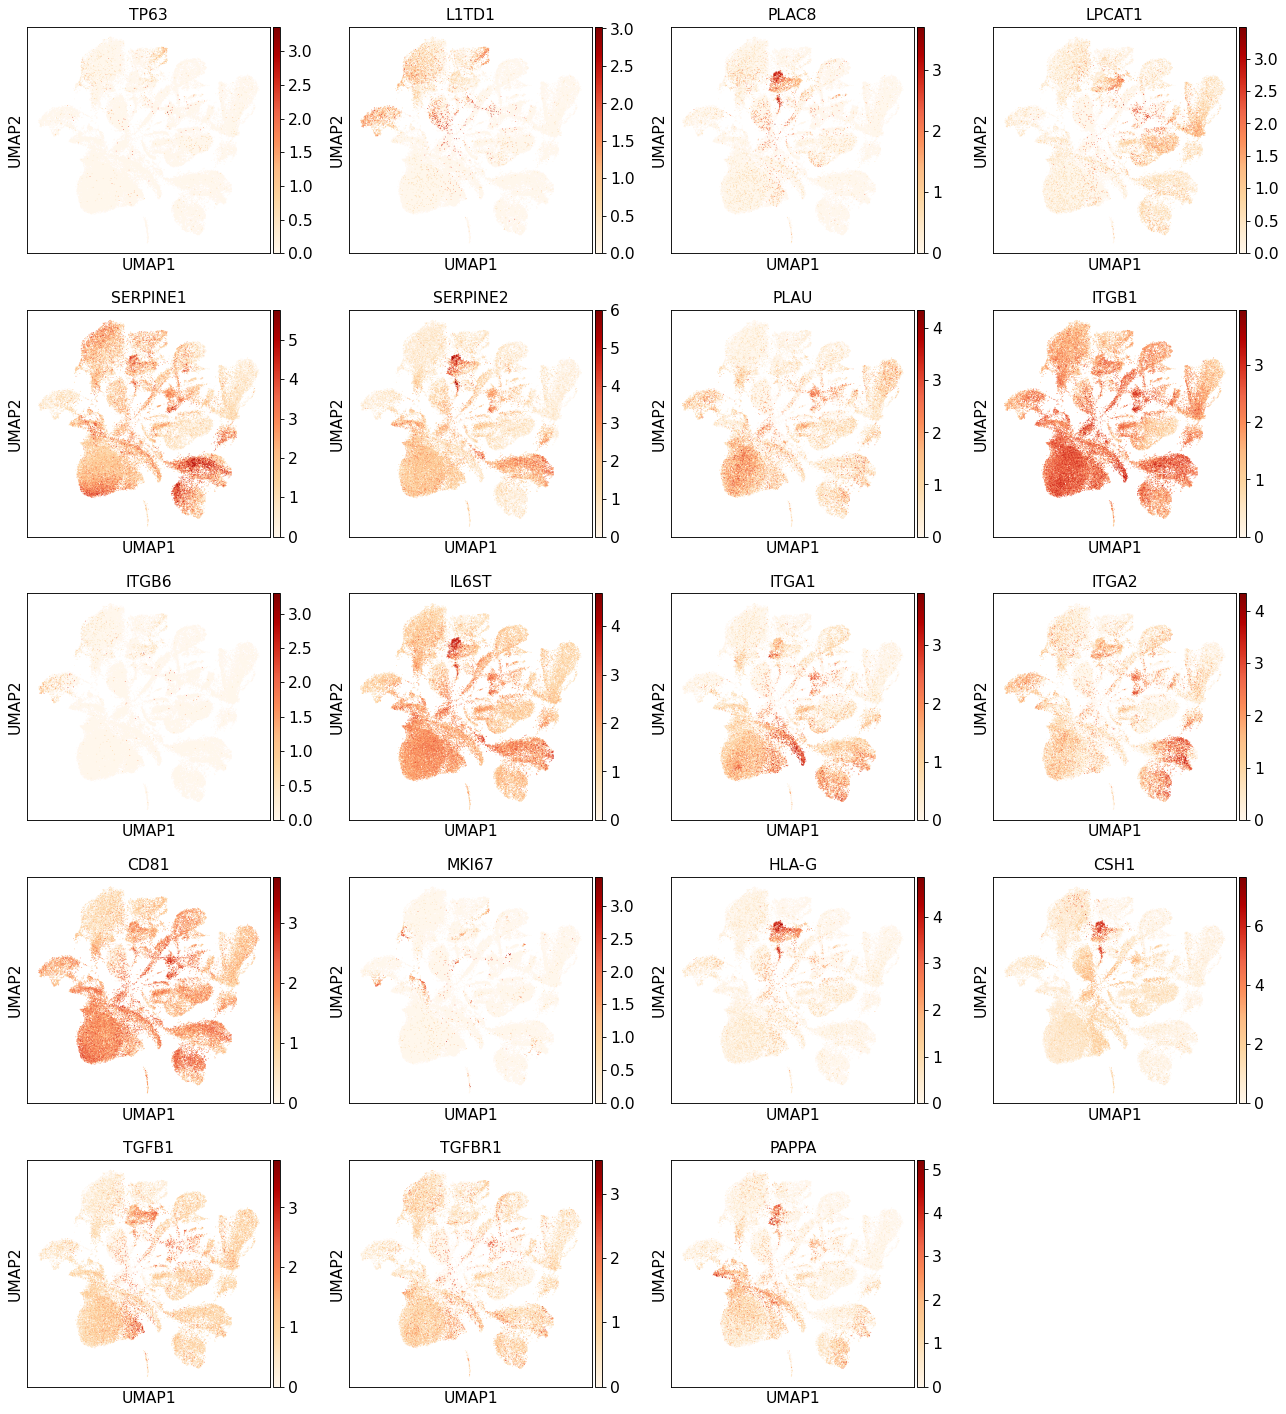

In [59]:
sc.pl.umap(adata, color=[ 'TP63','L1TD1', 'PLAC8','LPCAT1', 'SERPINE1', 'SERPINE2', 'PLAU','ITGB1', 'ITGB6','IL6ST', 'ITGA1', 'ITGA2','CD81','MKI67', 
                         'HLA-G', 'CSH1', 'TGFB1', 'TGFBR1','PAPPA'],color_map='OrRd', use_raw=False)

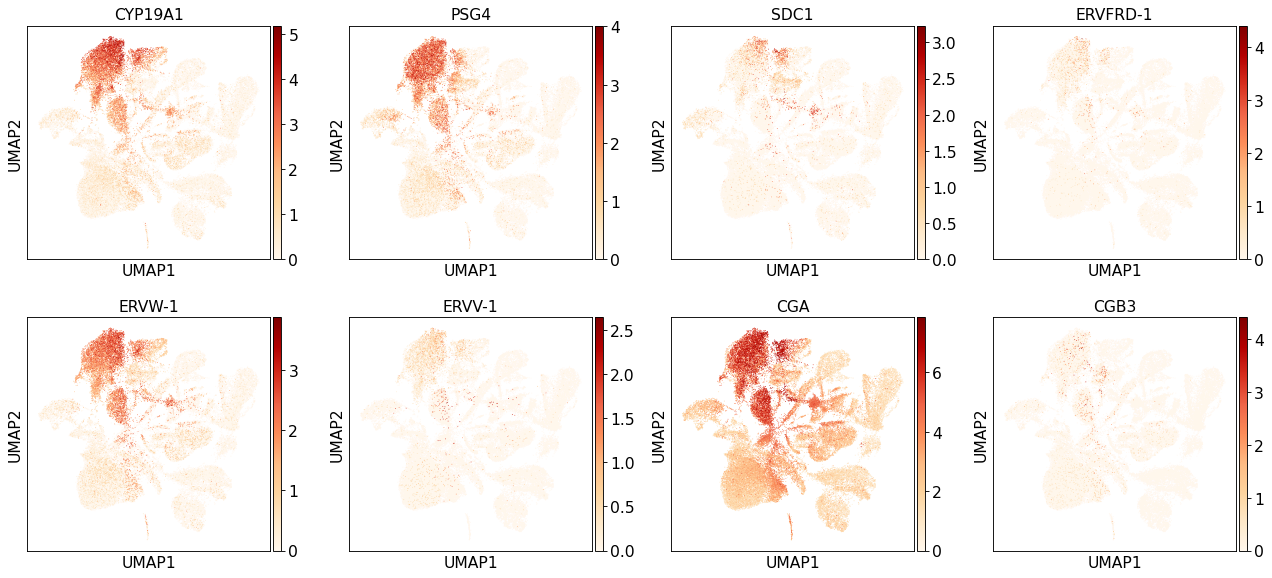

In [60]:
sc.pl.umap(adata, color=[ 'CYP19A1','PSG4', 'SDC1', 'ERVFRD-1','ERVW-1', 'ERVV-1', 'CGA','CGB3'],color_map='OrRd', use_raw=False)

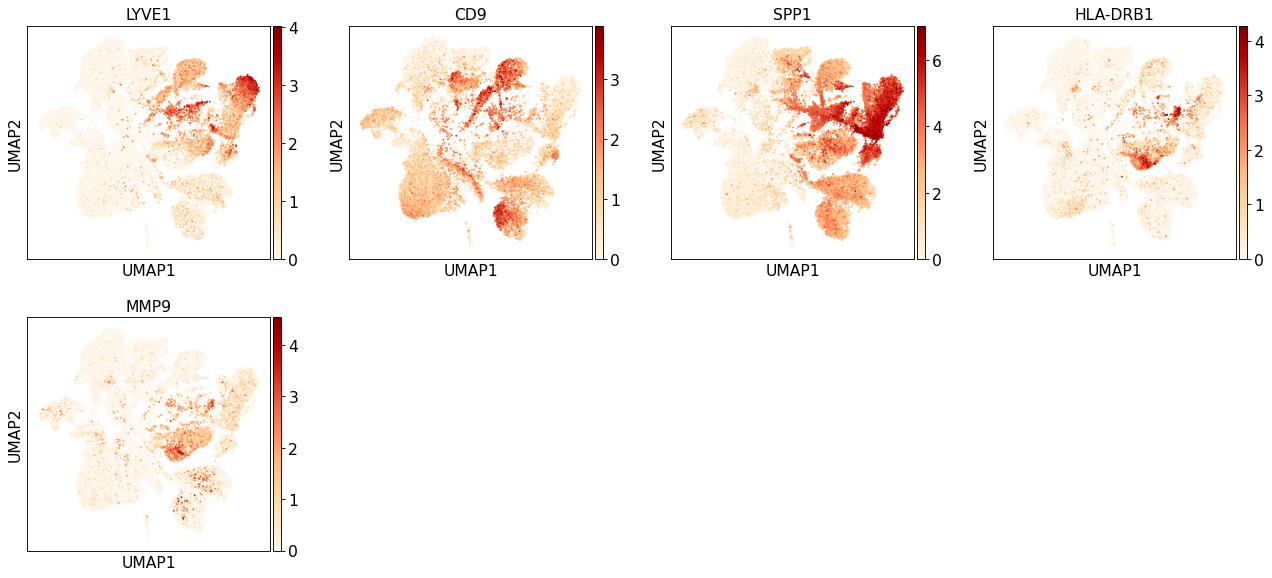

In [61]:
sc.pl.umap(adata, color=[ 'LYVE1','CD9', 'SPP1','HLA-DRB1', 'MMP9'],color_map='OrRd', use_raw=False, size=10)

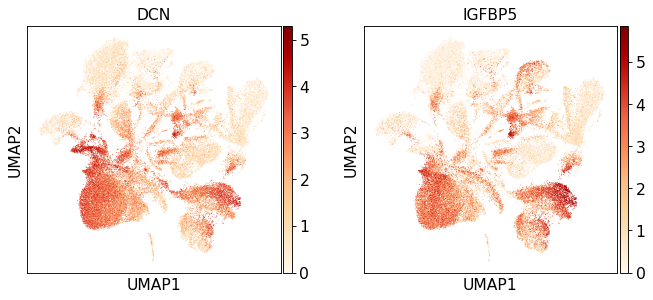

In [62]:
sc.pl.umap(adata, color=[ 'DCN','IGFBP5'],color_map='OrRd', use_raw=False)

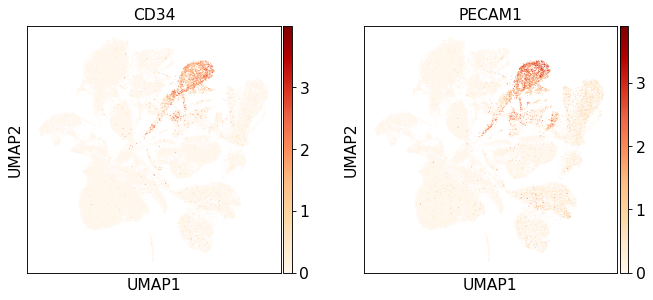

In [63]:
sc.pl.umap(adata, color=[ 'CD34','PECAM1'],color_map='OrRd', use_raw=False)

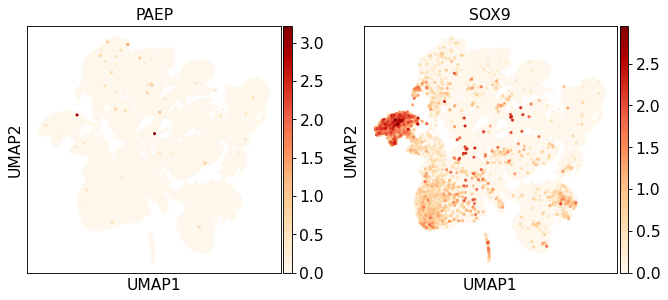

In [64]:
sc.pl.umap(adata, color=[ 'PAEP','SOX9'],color_map='OrRd', size=30, use_raw=False)

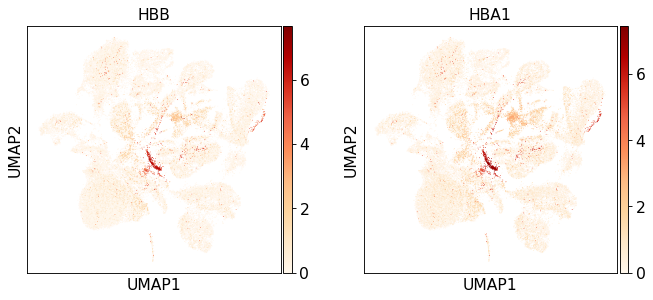

In [65]:
sc.pl.umap(adata, color=[ 'HBB', 'HBA1'],color_map='OrRd', use_raw=False)

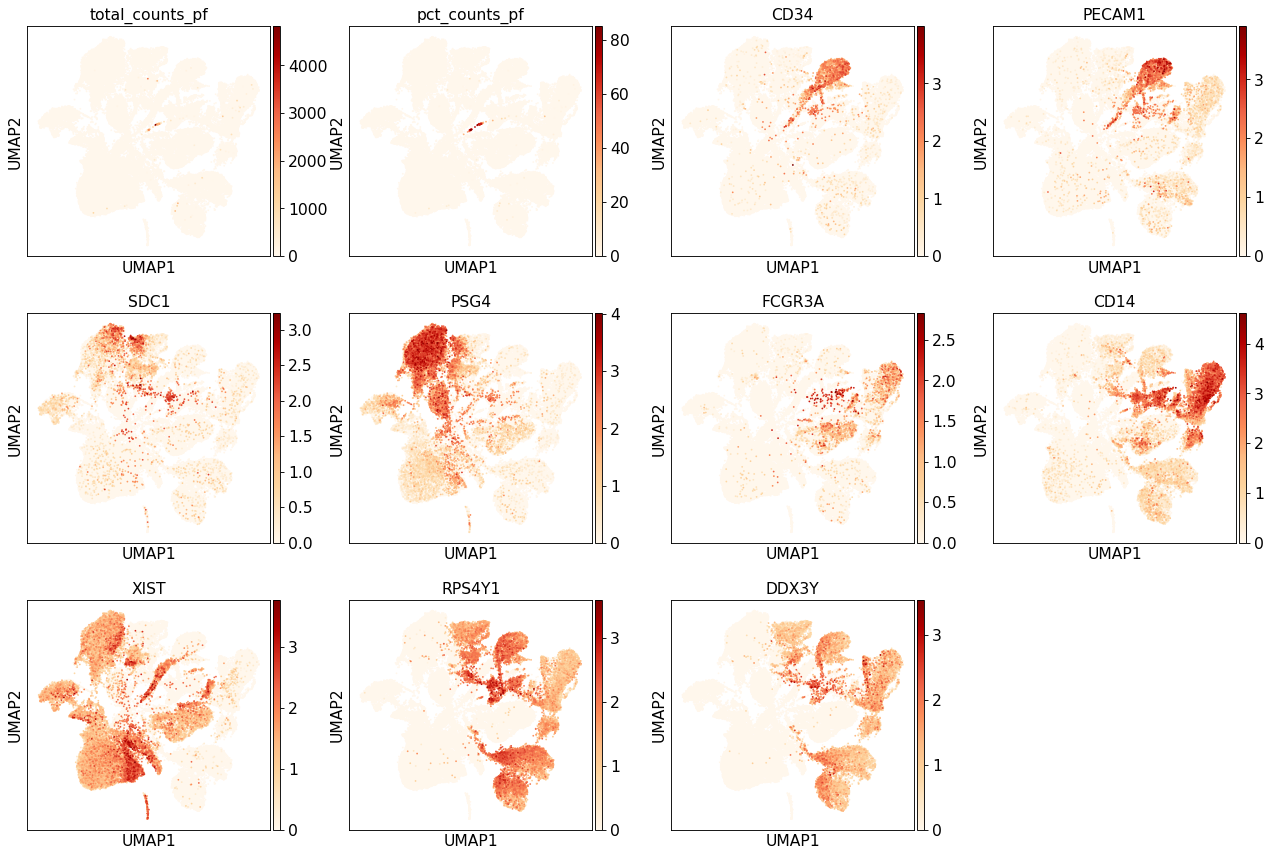

In [66]:
sc.pl.umap(adata, color=['total_counts_pf', 'pct_counts_pf', 'CD34', 'PECAM1', 'SDC1', 'PSG4','FCGR3A', 'CD14', 'XIST', 
                        'RPS4Y1','DDX3Y'],size=10, color_map='OrRd', use_raw=False)